Papers:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6788183/

In [1]:
import pandas as pd

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Paths
BASE_PATH = '/project/data'

image_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'

# Load Training Dataset

In [45]:
train = pd.read_csv(f'{BASE_PATH}/train.csv') #.set_index('image_id')

In [46]:
print(f'Shape of train data: {train.shape}')
print(f'Providers: {train.data_provider.unique()}')
print(f'ISUP grades: {train.isup_grade.unique()}')
print(f'Gleason scores: {train.gleason_score.unique()}')
print(f'Samples:\n{train.head()}')

Shape of train data: (10616, 4)
Providers: ['karolinska' 'radboud']
ISUP grades: [0 4 1 3 5 2]
Gleason scores: ['0+0' '4+4' '3+3' '4+3' 'negative' '4+5' '3+4' '5+4' '5+5' '5+3' '3+5']
Samples:
                           image_id data_provider  isup_grade gleason_score
0  0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
1  000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
2  0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
3  001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
4  001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0


In [47]:
# Check missing entries (i.e. NaN)
train.isna().sum()

image_id         0
data_provider    0
isup_grade       0
gleason_score    0
dtype: int64

# Load Test and Submission Dataset

In [48]:
test = pd.read_csv(f'{BASE_PATH}/test.csv').set_index('image_id')
sample_submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv').set_index('image_id')

In [49]:
print(f'Shape of test dataset: {test.shape}')
print(f'Columns of test dataset: \n{test.head()}')

Shape of test dataset: (3, 1)
Columns of test dataset: 
                                 data_provider
image_id                                      
005700be7e06878e6605e7a5a39de1b2       radboud
005c6e8877caf724c600fdce5d417d40    karolinska
0104f76634ff89bfff1ef0804a95c380       radboud


In [50]:
print(f'Shape of test dataset: {sample_submission.shape}')
print(f'Columns of test dataset: \n{sample_submission.head()}')

Shape of test dataset: (3, 1)
Columns of test dataset: 
                                  isup_grade
image_id                                    
005700be7e06878e6605e7a5a39de1b2           0
005c6e8877caf724c600fdce5d417d40           0
0104f76634ff89bfff1ef0804a95c380           0


# Preprocess Train dataset

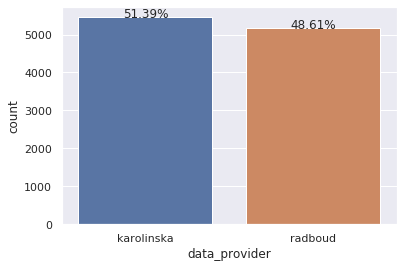

In [51]:
# Provider distribution
#res = train['data_provider'].value_counts()
#print(res.columns)
sns.set(style='darkgrid')
ax = sns.countplot(train['data_provider'], order=train['data_provider'].value_counts().index)
total_providers = len(train['data_provider'])
for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x()+p.get_width()/2, h, '{:.2f}%'.format(100*h/total_providers), ha='center')

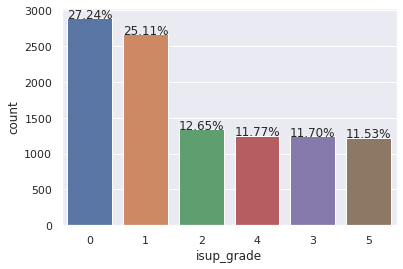

In [52]:
# ISUP distribution
ax = sns.countplot(train['isup_grade'], order=train['isup_grade'].value_counts().index)
total_isup = len(train['isup_grade'])
for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x()+p.get_width()/2, h+2, '{:.2f}%'.format(100*h/total_isup), ha='center')

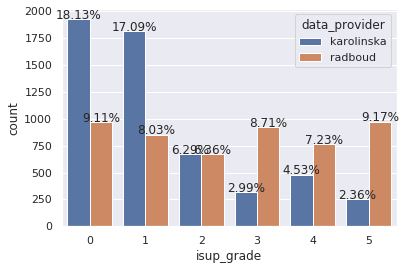

In [53]:
# Relative distribution of ISUP
ax = sns.countplot(x='isup_grade', hue='data_provider', data=train)
for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x()+p.get_width()/2, h+2, '{:.2f}%'.format(100*h/total_isup), ha='center')

# Display TIFF Images

In [54]:
import os
import openslide

((23904, 28664), (5976, 7166), (1494, 1791))


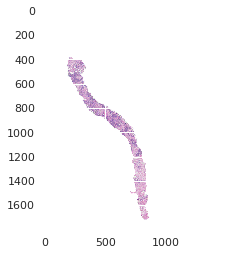

In [55]:
"""
Don't load the whole image as it causes the issue of out of memory
Image features
1. Can be in different rotations, which have no clinical value;
2. There are color differences between biopsies
"""
#image = openslide.OpenSlide(os.path.join(image_dir, f"{'0005f7aaab2800f6170c399693a96917'}.tiff"))
image = openslide.OpenSlide(os.path.join(image_dir, f"{'001c62abd11fa4b57bf7a6c603a11bb9'}.tiff"))
#plt.imshow(image)
print(image.level_dimensions)
#patch = image.read_region((7000,11000),0,(1000,1000))
patch = image.read_region((0,0),2,(1494,1791))
plt.imshow(patch)
#plt.show()
image.close()

In [56]:
import numpy as np

((23904, 28664), (5976, 7166), (1494, 1791))


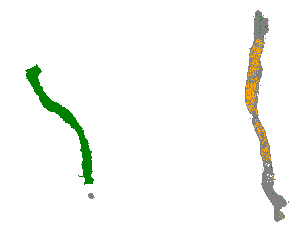

In [57]:
"""
1. Only Red channel has values;
2. Masks from two medical centers use different labels
    2.1. Radboundumc: 6 values
    2.2. Karolinska: 3 values
3. There are about 100 images having wrong masks,
    3.1. 4 only have background values
    3.2. 85 don't contain cancerous mark though they have non-zero ISUP
"""
#mask = openslide.OpenSlide(os.path.join(mask_dir, f"{'0005f7aaab2800f6170c399693a96917'}_mask.tiff"))
mask_karo = openslide.OpenSlide(os.path.join(mask_dir, f"{'001c62abd11fa4b57bf7a6c603a11bb9'}_mask.tiff"))
mask_rad = openslide.OpenSlide(os.path.join(mask_dir, f"{'0018ae58b01bdadc8e347995b69f99aa'}_mask.tiff"))
karo_data = mask_karo.read_region((0,0), mask_karo.level_count-1, mask_karo.level_dimensions[-1])
rad_data = mask_rad.read_region((0,0), mask_rad.level_count-1, mask_rad.level_dimensions[-1])
print(mask_karo.level_dimensions)
cmap = matplotlib.colors.ListedColormap(['white', 'gray', 'green', 'yellow', 'orange', 'red'])
#print(mask_data)
f, ax = plt.subplots(1,2)
ax[0].imshow(np.asarray(karo_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
ax[0].axis('off')
ax[1].imshow(np.asarray(rad_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
ax[1].axis('off')
#print(np.asarray(mask_data).shape)
#print(np.asarray(mask_data)[450,250:300,0])
mask_karo.close()
mask_rad.close()

In [62]:
rad_samples = train[(train.isup_grade == 4) & (train.data_provider == 'radboud')].image_id.head(4).reset_index(drop=True)

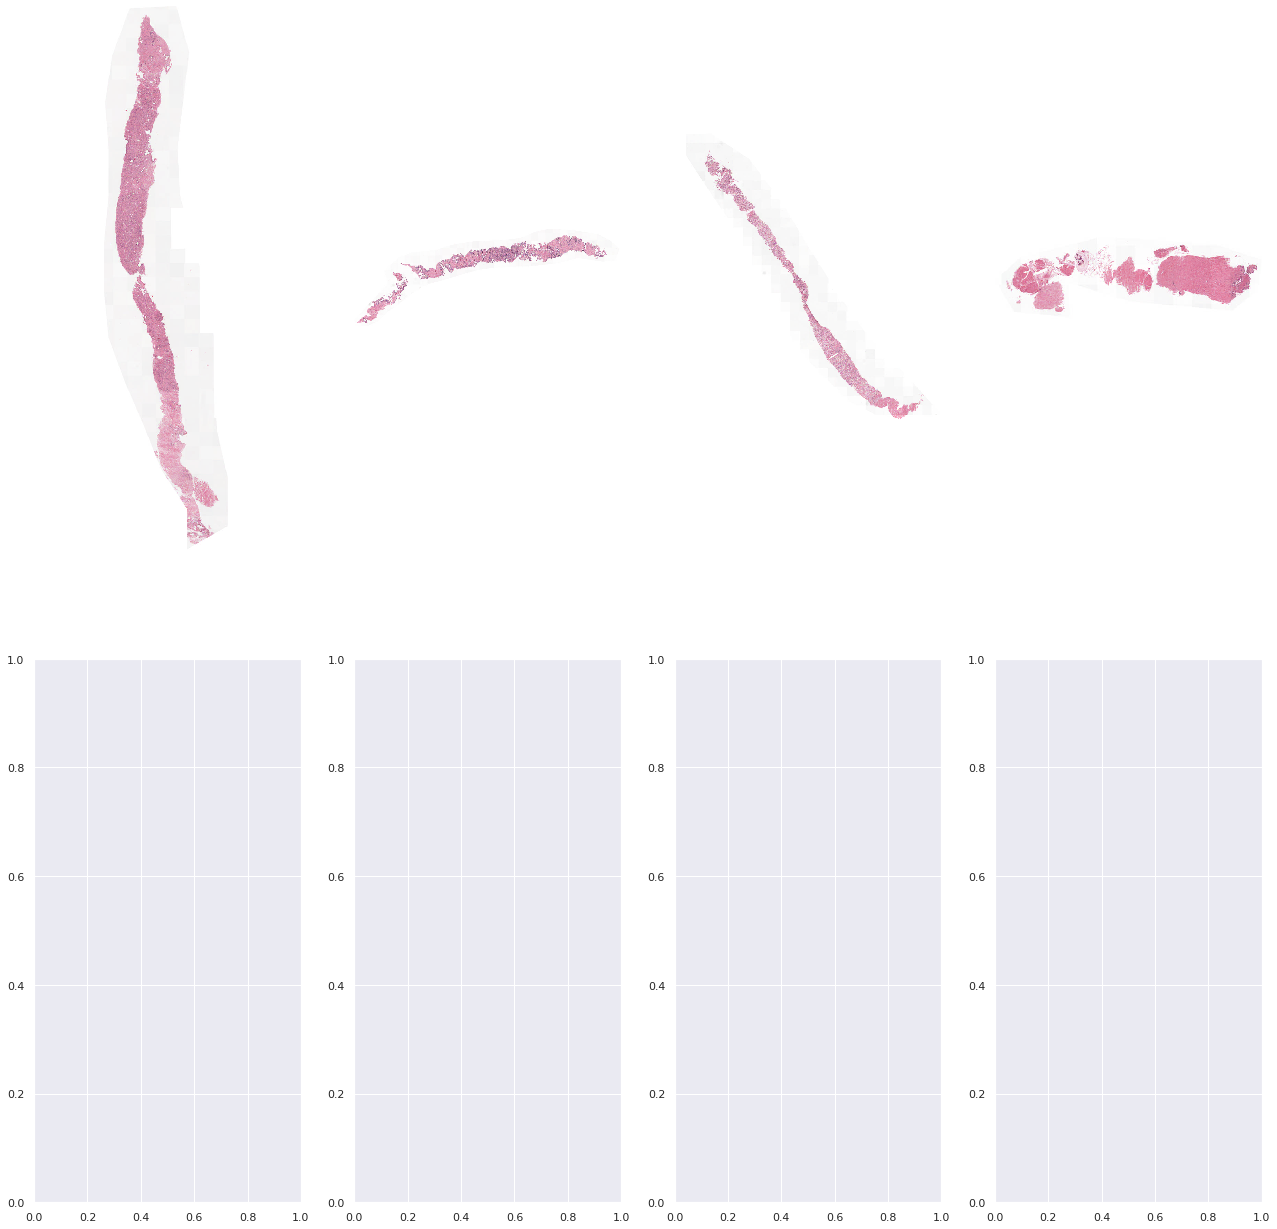

In [64]:
def print_image(image_id, ax):
    biopsy_img = openslide.OpenSlide(os.path.join(image_dir, f'{image_id}.tiff'))
    img_data = biopsy_img.read_region((0,0),biopsy_img.level_count-1,biopsy_img.level_dimensions[-1])
    ax.imshow(img_data)
    ax.axis('off')
    biopsy_img.close()

f, ax = plt.subplots(nrows=2, ncols=4, figsize=(22, 22))
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        if i%2 == 0:
            print_image(rad_samples[j], col)